<a href="https://colab.research.google.com/github/sheha919/Stroke_Prediction/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Information about the dataset

source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

**Attribute Information**

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

#Import Libraries


In [286]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay\
,precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display='diagram')

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as smote_pipe
from sklearn.decomposition import PCA

#Load Data

In [287]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [288]:
#make a copy
ml_df = df.copy()
ml_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#Explore Data

In [289]:
ml_df.shape

(5110, 12)

In [290]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [291]:
#checking for duplicates
ml_df.duplicated().sum()

0

No duplicate data

In [292]:
#checking for missing data
ml_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

'bmi' Column has 201 missing data. I will require to impute using Simple Imputer at the data preprocessing step.

In [293]:
#checking the balance level of data
ml_df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

The data set is unbalanced, need to fix this. 

In [294]:
#checking for inconsistencies in categorical data
data_types = ml_df.dtypes
str_object = data_types[data_types=='object'].index

for i in str_object:
  print(f'Column Name: {i}')
  print(ml_df[i].value_counts())
  print('\n')

Column Name: gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Column Name: ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64


Column Name: work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Column Name: Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


Column Name: smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64




- Seems like there are no inconsistencies in the categorical data
- In the description of database, it is mentioned that "Unknown" in smoking_status means that the information is unavailable for this patient. Therefore, the 'unknown' values can be considered as missing data.
- All categorical data columns ontain nominal data

In [295]:
#replacing 'unknown' with NAN
ml_df['smoking_status'].replace('Unknown', np.nan, inplace = True)
ml_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [296]:
#rechecking missing data
ml_df.isna().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

Now, both 'bmi' and 'smoking_status' have missing data


In [297]:
#checking the inconsistencies in numerical data
ml_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- 'id' column does not provide useful data to the analysis. Therefore, it can be removed.

In [298]:
ml_df.drop(columns = ['id'], axis = 1, inplace = True)
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Since it is suspicious to have a decimal number as the age, just explore the 'age' column 

In [299]:
#explore the age column
ml_df[ml_df['age']<1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
363,Female,0.64,0,0,No,children,Urban,83.82,24.9,NaN,0
376,Female,0.88,0,0,No,children,Rural,88.11,15.5,NaN,0
564,Female,0.32,0,0,No,children,Rural,73.71,16.2,NaN,0
982,Male,0.88,0,0,No,children,Rural,157.57,19.2,NaN,0
996,Male,0.24,0,0,No,children,Rural,118.87,16.3,NaN,0
1093,Female,0.32,0,0,No,children,Rural,55.86,16.0,NaN,0
1206,Female,0.72,0,0,No,children,Urban,66.36,23.0,NaN,0
1317,Male,0.80,0,0,No,children,Rural,98.67,17.5,NaN,0
1600,Male,0.40,0,0,No,children,Urban,109.56,14.3,NaN,0
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,NaN,0


- Seems like all the entries which have less than 1 year as the age are children. Therefore, no need to change anything in 'age column'.

- All other numerical columns look fine too.

# Data Analysis and Visualization

## Univarient Analysis

In [300]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [301]:
data_types = ml_df.dtypes
str_num = data_types[data_types!='object'].index
str_num

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')

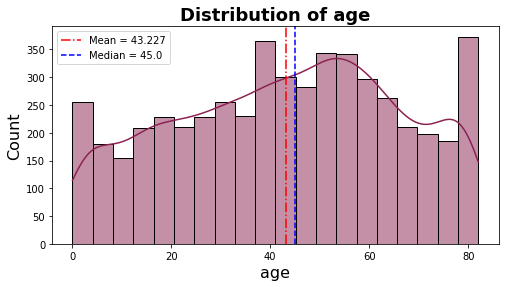

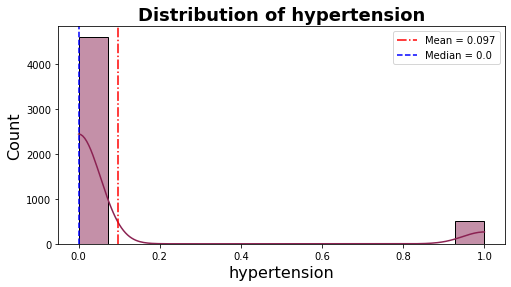

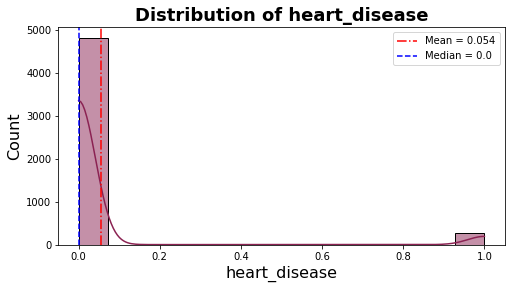

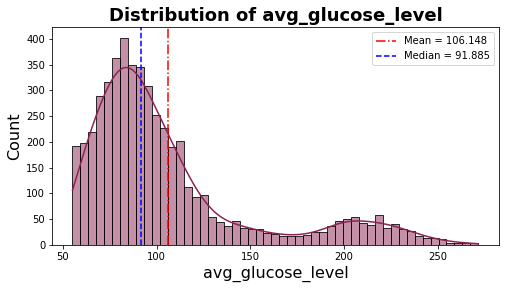

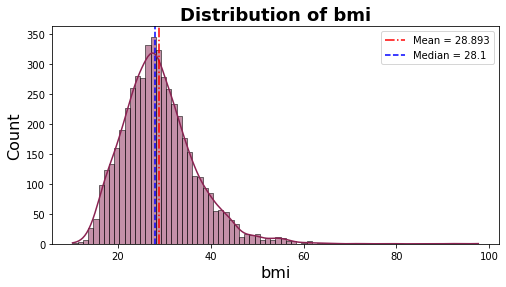

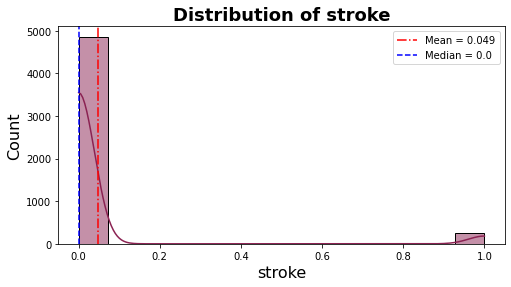

In [302]:
from pyparsing.helpers import line
for i in str_num:
  fig, ax = plt.subplots(figsize= (8,4))
  sns.histplot(data = ml_df, x = i, bins = 'auto', kde=True, color = '#8B2252', palette= 'magma')
  avg = ml_df[i].mean()
  ax.axvline(avg, ls = '-.', color = 'red', label = f'Mean = {round(avg,3)}')
  median = ml_df[i].median()
  ax.axvline(median, ls = '--', color = 'blue', label = f'Median = {round(median,3)}')
  ax.set_xlabel(i, fontsize = 16)
  ax.set_ylabel('Count', fontsize =16)
  ax.set_title(f'Distribution of {i}', fontsize = 18, fontweight = 'bold')
  ax.legend();



- Above histrogams illustrate the distribution of each feature with its mean and median values.
- According to them, not any of features showing outliers.

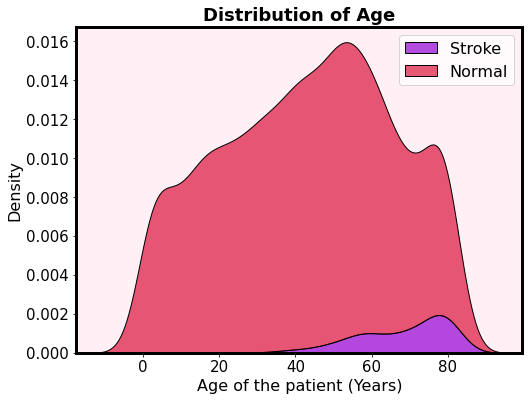

In [324]:
fig, ax =plt.subplots(figsize=(8,6), facecolor='w')
ax.set_facecolor('lavenderblush')
palette_dict = {0: 'crimson' ,  1: 'darkviolet'}
sns.kdeplot(data = ml_df, x = 'age', hue = 'stroke', multiple="stack",  palette= palette_dict, alpha =0.7, ax= ax)
ax.legend(labels = ['Stroke', 'Normal'], bbox_to_anchor=(1,1), fontsize=16)
ax.tick_params(labelsize=15)
ax.set_xlabel('Age of the patient (Years)', fontsize = 16)
ax.set_ylabel('Density', fontsize =16)
ax.set_title(f'Distribution of Age', fontsize = 18, fontweight = 'bold')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3);

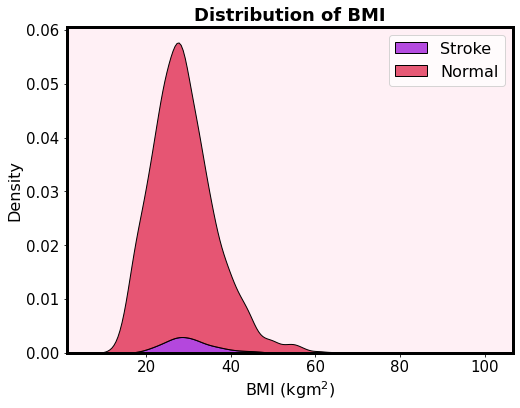

In [327]:
fig, ax =plt.subplots(figsize=(8,6), facecolor='w')
ax.set_facecolor('lavenderblush')
palette_dict = {0: 'crimson' ,  1: 'darkviolet'}
sns.kdeplot(data = ml_df, x = 'bmi', hue = 'stroke', multiple="stack",  palette= palette_dict, alpha =0.7, ax= ax)
ax.legend(labels = ['Stroke', 'Normal'], bbox_to_anchor=(1,1), fontsize=16)
ax.tick_params(labelsize=15)
ax.set_xlabel('BMI (kgm$^2$)', fontsize = 16)
ax.set_ylabel('Density', fontsize =16)
ax.set_title(f'Distribution of BMI', fontsize = 18, fontweight = 'bold')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3);

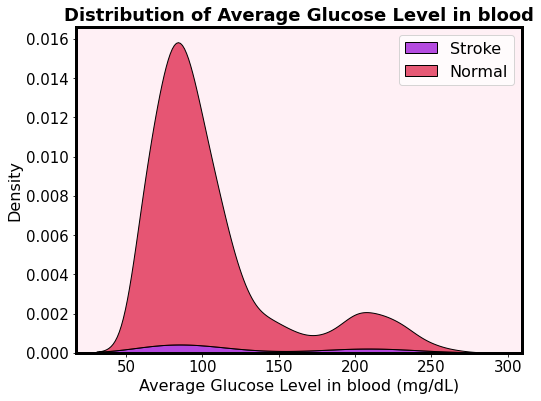

In [325]:
fig, ax =plt.subplots(figsize=(8,6), facecolor='w')
ax.set_facecolor('lavenderblush')
palette_dict = {0: 'crimson' ,  1: 'darkviolet'}
sns.kdeplot(data = ml_df, x = 'avg_glucose_level', hue = 'stroke', multiple="stack",  palette= palette_dict, alpha =0.7, ax= ax)
ax.legend(labels = ['Stroke', 'Normal'], bbox_to_anchor=(1,1), fontsize=16)
ax.tick_params(labelsize=15)
ax.set_xlabel('Average Glucose Level in blood (mg/dL)', fontsize = 16)
ax.set_ylabel('Density', fontsize =16)
ax.set_title(f'Distribution of Average Glucose Level in blood', fontsize = 18, fontweight = 'bold')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3);

##Multivariate Analysis 

In [151]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Text(0.5, 1.0, 'Correlation between features')

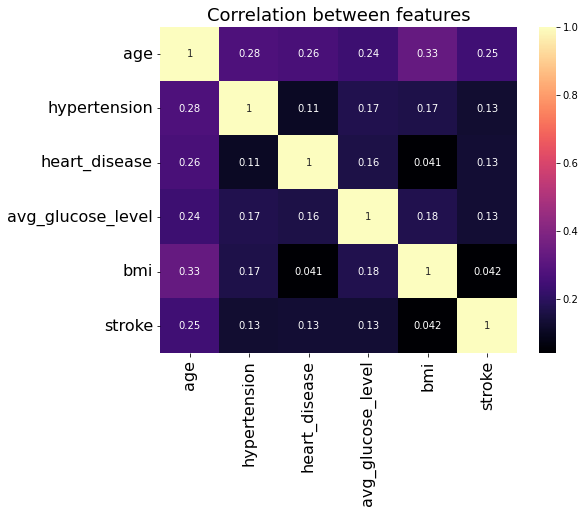

In [152]:
corr = ml_df.corr()
plt.figure(figsize = (8,6))
sns.heatmap(data =corr, annot = True, cmap = 'magma')
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)
plt.title('Correlation between features', fontsize =18)

- The highest correlation shows between age and BMI which is 0.33
- The lowest correlation shows between BMI and having a heart disease or not

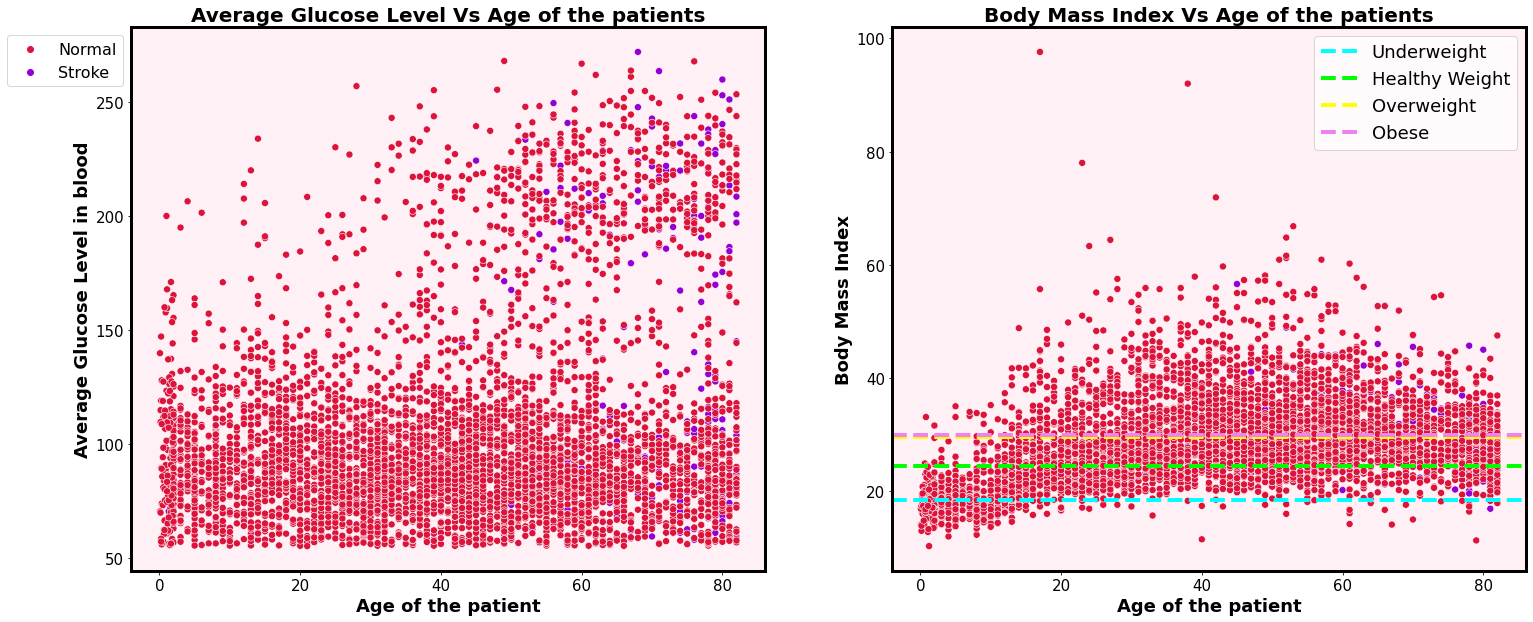

In [153]:
fig, axes = plt.subplots(1,2, figsize = (25,10), facecolor='w')
palette_dict = {0: 'crimson' ,  1: 'darkviolet'}
sns.scatterplot(data = ml_df, x = 'age', y = 'avg_glucose_level', hue = 'stroke', palette=palette_dict, ax= axes[0], marker='o', s=50)
legend_labels, _= axes[0].get_legend_handles_labels()
axes[0].legend(legend_labels, ['Normal', 'Stroke'], bbox_to_anchor=(0,1), fontsize=16)
axes[0].tick_params(labelsize=15)
axes[0].set_xlabel('Age of the patient', fontsize = 18, fontweight = 'bold')
axes[0].set_ylabel('Average Glucose Level in blood', fontsize = 18, fontweight = 'bold')
axes[0].set_title('Average Glucose Level Vs Age of the patients', fontsize = 20, fontweight = 'bold')
axes[0].set_facecolor('lavenderblush')
for axis in ['top','bottom','left','right']:
  axes[0].spines[axis].set_linewidth(3)


palette_dict = {0: 'crimson' ,  1: 'darkviolet'}
sns.scatterplot(data = ml_df, x = 'age', y = 'bmi', hue = 'stroke', palette=palette_dict, ax = axes[1], legend= False, marker='o', s=50)
axes[1].set_xlabel('Age of the patient', fontsize = 18, fontweight = 'bold')
axes[1].set_ylabel('Body Mass Index', fontsize = 18, fontweight = 'bold')
axes[1].set_title('Body Mass Index Vs Age of the patients', fontsize = 20, fontweight = 'bold')
axes[1].tick_params(labelsize=15)
axes[1].axhline(18.5, ls = '--', color = 'aqua', label = 'Underweight', linewidth= 4)
axes[1].axhline(24.5, ls = '--', color = 'lime', label = 'Healthy Weight', linewidth= 4)
axes[1].axhline(29.5, ls = '--', color = 'yellow', label = 'Overweight', linewidth= 4)
axes[1].axhline(30, ls = '--', color = 'violet', label = 'Obese', linewidth= 4)
axes[1].set_facecolor('lavenderblush')
for axis in ['top','bottom','left','right']:
  axes[1].spines[axis].set_linewidth(3)

axes[1].legend(fontsize = 18)

- Most of the patients have average glucose level below ~ 140. But the patients with higher than 140 are increasing with as the age increment. 
- Everyone with stroke fall above the age of 40 years.
- Most of patients are below the ~ 50 level of BMI.
- According to the CDC, patients can be catergorized as;
  - BMI is less than 18.5: Underweight range
  - BMI is 18.5 to 24.9: Healthy Weight range
  - BMI is 25.0 to 29.9: Overweight range
  - BMI is 30.0 or higher: Obese range


(source: https://www.cdc.gov/healthyweight/assessing/index.html)


- Most of the underweight patients fall under 20 years
- The majority of patients suffer from obesity are in between 20 and 60 years of age. 

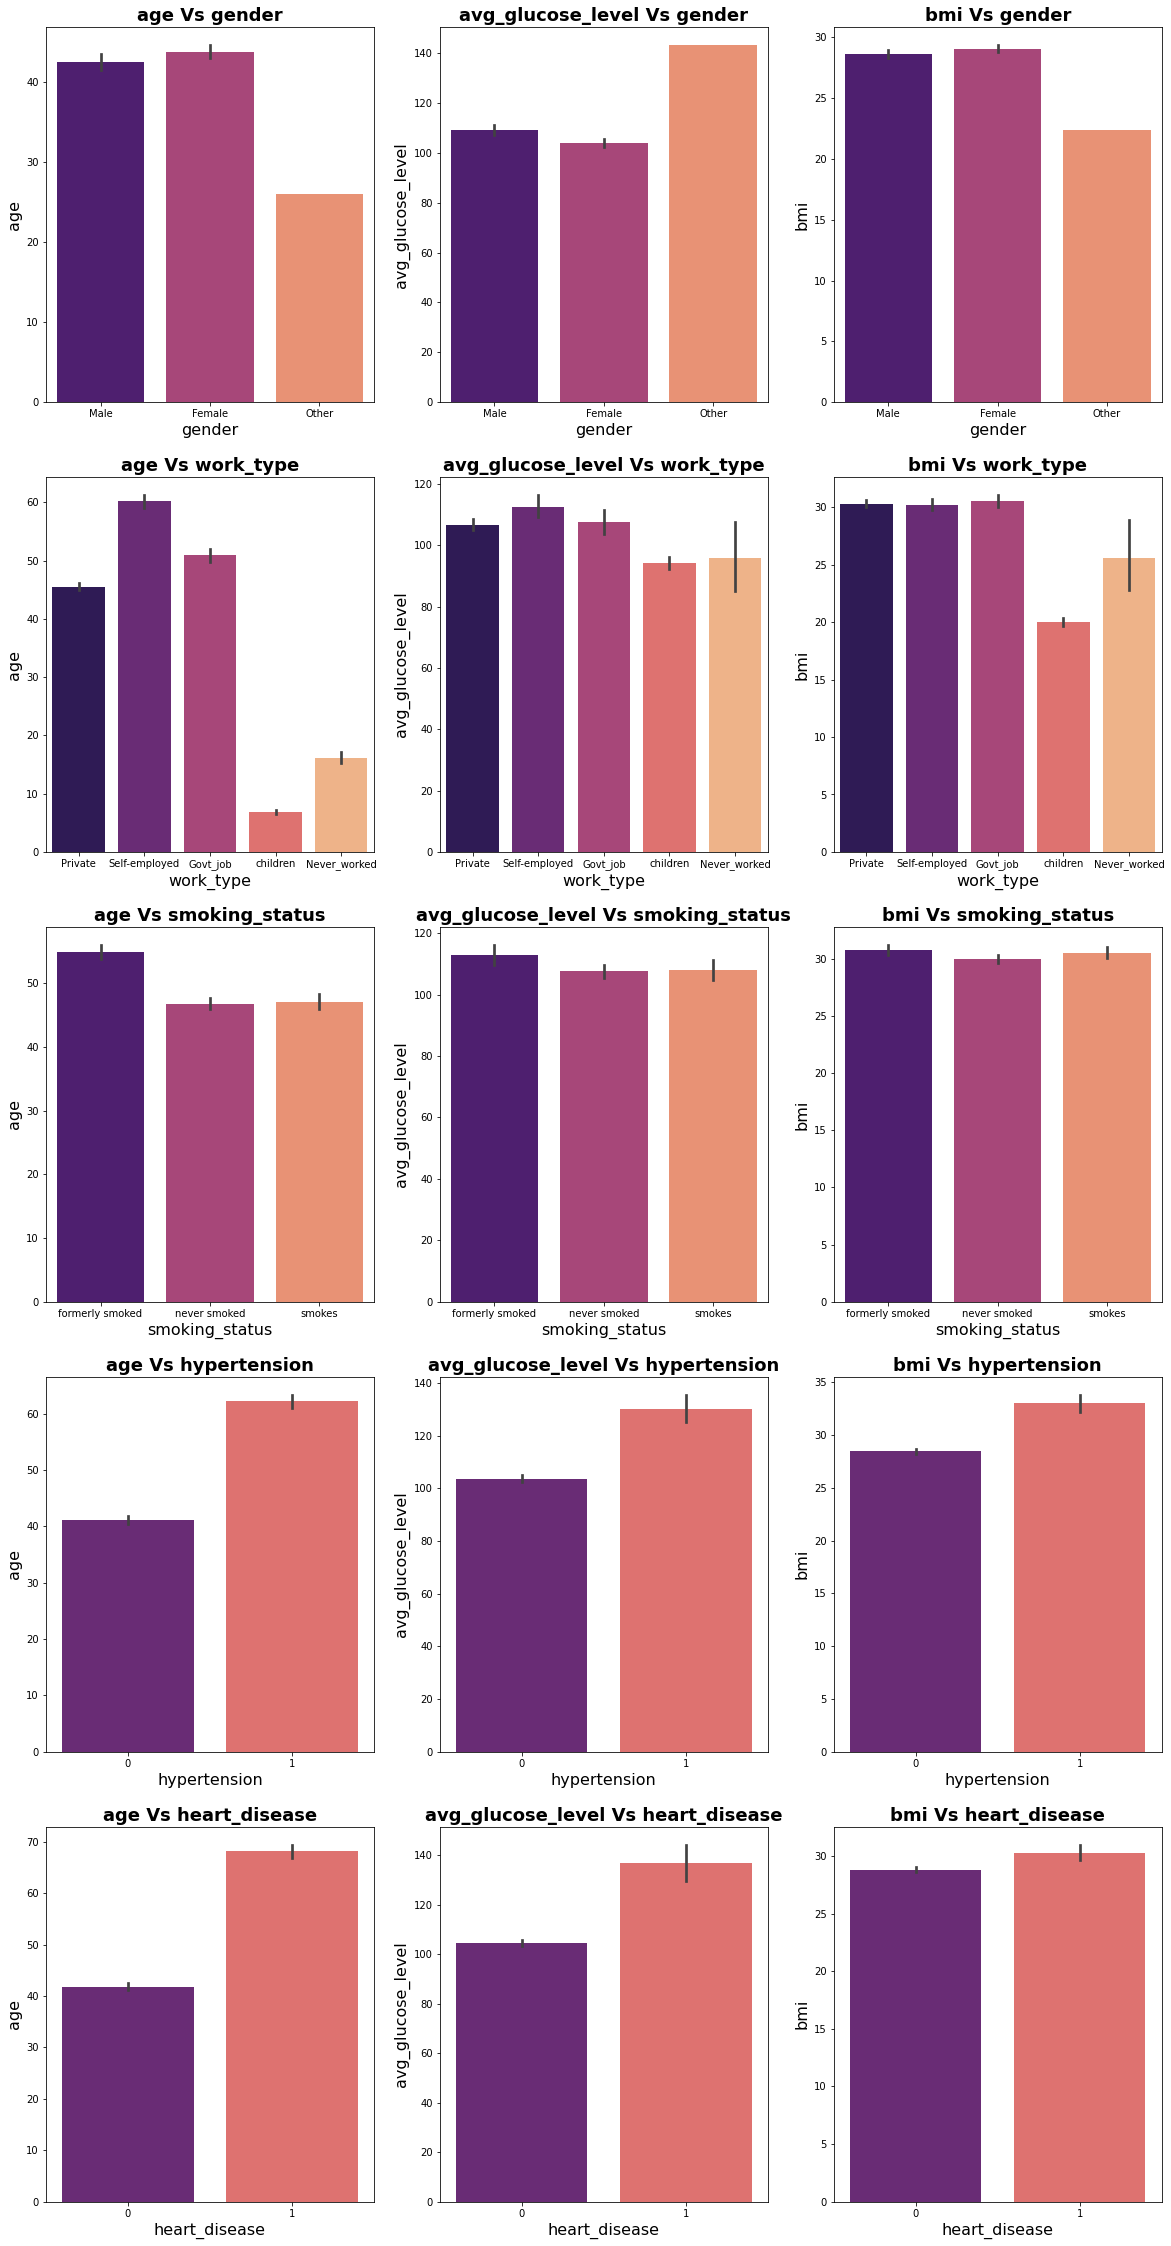

In [154]:
cat_col = ['gender', 'work_type', 'smoking_status', 'hypertension',	'heart_disease']
num_col = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(len(cat_col), len(num_col), figsize = (20,40))
for i, icol in enumerate(cat_col):
  for j, jcol in enumerate(num_col):
    sns.barplot(data = ml_df, x = icol, y = jcol, palette="magma", ax = axes[i,j])
    axes[i,j].set_xlabel(icol, fontsize = 16)
    axes[i,j].set_ylabel(jcol, fontsize = 16)
    axes[i,j].set_title(f'{jcol} Vs {icol}', fontsize = 18, fontweight = 'bold');


According to the above grid of bar charts;
  - Male and female patients have almost similar mean age, glucose levels and BMI
  - For adult patients, the BMI and glucose levels do not depend on the job type. (Never worked patients can be consider as teenagers, thus not catergorized as adults)
  - Seems like average glucose and BMI do not vary on the smoking status much.
  - Patients with hypertension and heart disease are also suffering from obesity and prediabetes or diabates.
  

According to CDC;
  - Diabetes:	above	126 mg/dL 
  - Prediabetes:	100 – 125 mg/dL	
  - Normal: Below 99 mg/dL 
  
(source: https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=Fasting%20Blood%20Sugar%20Test&text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.)

#Evaluvate Function

In [155]:
## define the evaluate_classification function here

def evaluate_classiffication(pipe, X, y, label):
  test_preds = pipe.predict(X)

  print('---'*20)
  print(f"[i] CLASSIFICATION REPORT FOR: {label}")
  print('---'*20)

  # print the classiffication report from the test data
  print(classification_report(y, test_preds))

  fig, axes = plt.subplots(1,2, figsize=(15,5))

  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y, test_preds, 
               normalize='true', cmap='Reds',
               ax = axes[0]);

  RocCurveDisplay.from_estimator(pipe, X, y, ax=axes[1])
  plt.show()

#Data Preprocessing

In [156]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [157]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     3566 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [158]:
#missing data
ml_df.isna().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

##Validate Split

In [159]:
y = ml_df['stroke']
X = ml_df.drop(columns = ['stroke'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

##Instantiate Column Transformers

In [160]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown= 'ignore')
median_imputer = SimpleImputer(strategy = 'median')
freq_imputer = SimpleImputer(strategy = 'most_frequent')

## Instanttiate Column selectors

In [161]:
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include='object')

##Instantiate preprocessor

In [162]:
num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b19ae80>)])

#Application of PCA

In [163]:
print(f'Shape of X_train before PCA: {X_train.shape}')

Shape of X_train before PCA: (3832, 10)


In [164]:
processed_x = preprocessor.fit_transform(X_train)
print(f'Shape of processed X_train before PCA: {processed_x.shape}')
pca = PCA()
print(f'Shape of processed X_train after PCA: {pca.fit_transform(processed_x).shape}')

Shape of processed X_train before PCA: (3832, 20)
Shape of processed X_train after PCA: (3832, 20)


Text(0, 0.5, 'Proportion of Explained Variance')

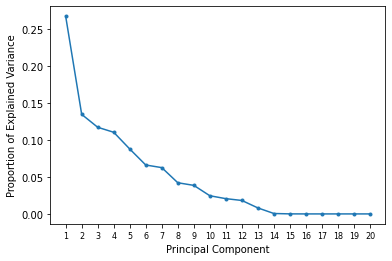

In [165]:
plt.plot(range(1,21), pca.explained_variance_ratio_, marker = '.')
plt.xticks(ticks = range(1, 21), fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

- The variance is approximately zero from 14th principle component to 20th. 
- Therefore, n_component = 13 is seleced for further optimizations.

In [166]:
#define the function for pca model
def pca_model(model):
  pca = PCA(n_components =13)
  model_pca_pipe = make_pipeline(preprocessor, pca, model)
  model_pca_pipe.fit(X_train, y_train)

  return (model_pca_pipe)

## Addressing Class Imbalance with SMOTE

In [167]:
#define the function for smote model
def smote_model(model):
  smote = SMOTE(sampling_strategy='auto', random_state=42)
  model_smote_pipe = smote_pipe(preprocessor, smote, model)
  model_smote_pipe.fit(X_train, y_train)

  return (model_smote_pipe)

## Incoporating both PCA and SMOTE

In [168]:
#define the function for smote pca model
def smote_pca_model(model):
  smote = SMOTE(sampling_strategy='auto', random_state=42)
  pca = PCA(n_components =13)
  model_smote_pca_pipe = smote_pipe(preprocessor, pca, smote, model)
  model_smote_pca_pipe.fit(X_train, y_train)
  
  return (model_smote_pca_pipe)


#Logistic Regression Model

## Initial model

In [169]:
logreg= LogisticRegression(random_state =42, max_iter =1000)
logreg_pipe = make_pipeline(preprocessor, logreg)
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b19ae80>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3645
           1       0.00      0.00      0.00       187

    accuracy                           0.95      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.90      0.95      0.93      3832



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


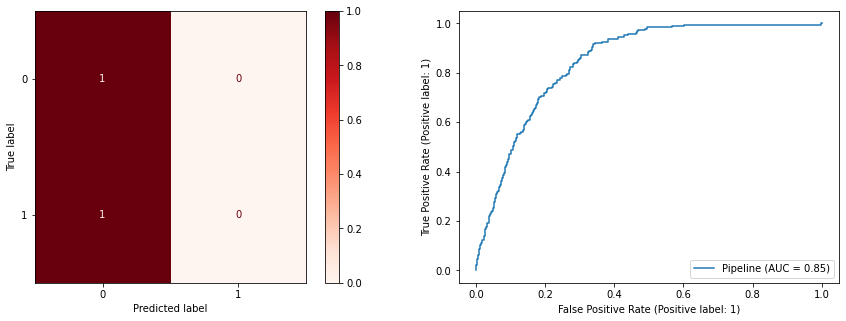

In [170]:
evaluate_classiffication(logreg_pipe, X_train, y_train, label="Train Data")

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       1.00      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.98      0.51      0.50      1278
weighted avg       0.95      0.95      0.93      1278



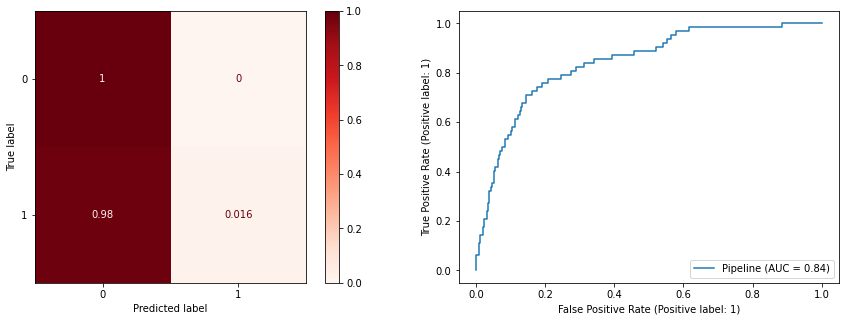

In [171]:
evaluate_classiffication(logreg_pipe, X_test, y_test, label="Test Data")

- In this problem, we have to minimize the number of false negatives to reduce the risk on the patient.
- Therefore, the recall score is a very important metric to measure.
- But in initial logistic regression model produced a very low value(0.016) for positive cases in test data. 

## with PCA

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3645
           1       0.00      0.00      0.00       187

    accuracy                           0.95      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.90      0.95      0.93      3832



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


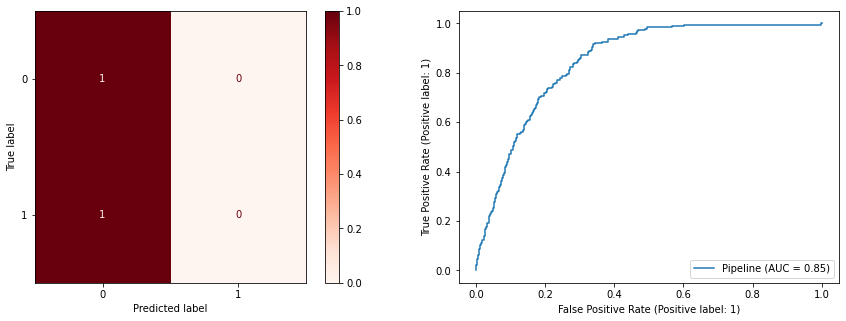

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       1.00      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.98      0.51      0.50      1278
weighted avg       0.95      0.95      0.93      1278



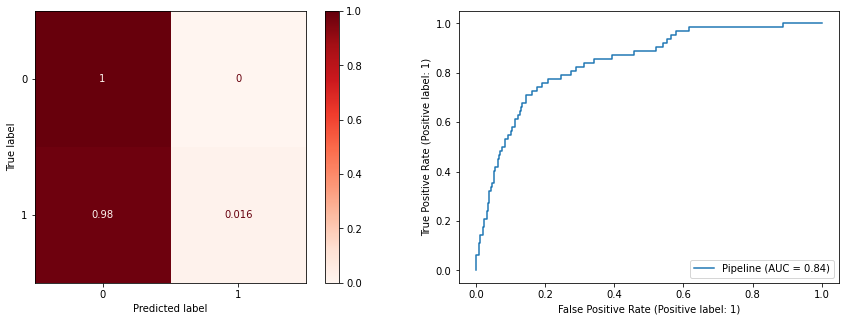

In [172]:
logreg_pca_pipe = pca_model(LogisticRegression(random_state =42, max_iter =1000))
evaluate_classiffication(logreg_pca_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(logreg_pca_pipe, X_test, y_test, label="Test Data")

Applying just PCA did not affect the results.

## with SMOTE


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      3645
           1       0.14      0.79      0.24       187

    accuracy                           0.75      3832
   macro avg       0.56      0.77      0.54      3832
weighted avg       0.94      0.75      0.82      3832



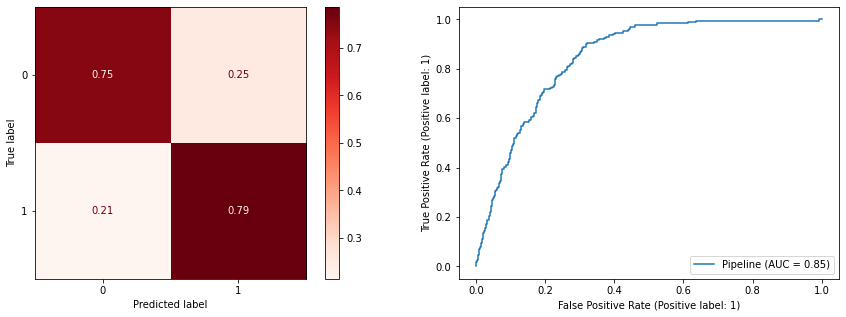

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1216
           1       0.13      0.76      0.22        62

    accuracy                           0.74      1278
   macro avg       0.56      0.75      0.53      1278
weighted avg       0.94      0.74      0.81      1278



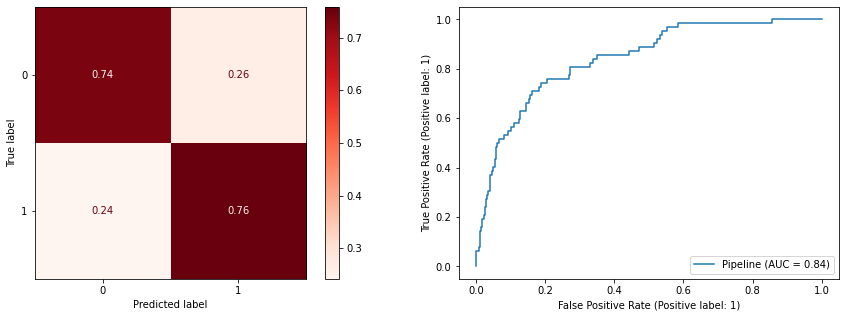

In [173]:
logreg_smote_pipe = smote_model(LogisticRegression(random_state =42, max_iter =1000))
evaluate_classiffication(logreg_smote_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(logreg_smote_pipe, X_test, y_test, label="Test Data")

- There is a significant improvement when apply the SMOTE.
- It reduced nearly 98% of false negatives to 24%  

##with both PCA and SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      3645
           1       0.14      0.79      0.24       187

    accuracy                           0.75      3832
   macro avg       0.56      0.77      0.54      3832
weighted avg       0.94      0.75      0.82      3832



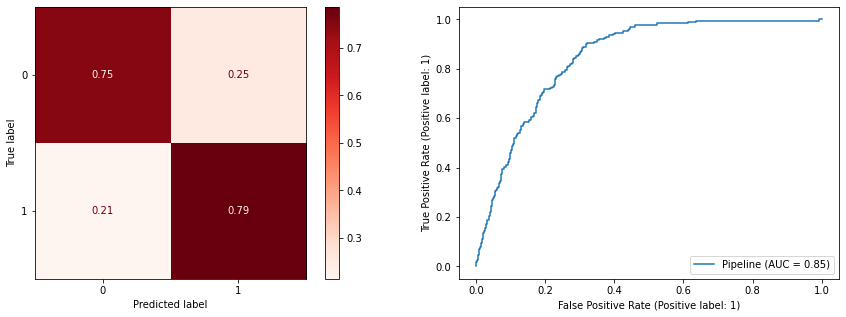

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1216
           1       0.13      0.76      0.22        62

    accuracy                           0.74      1278
   macro avg       0.56      0.75      0.53      1278
weighted avg       0.94      0.74      0.81      1278



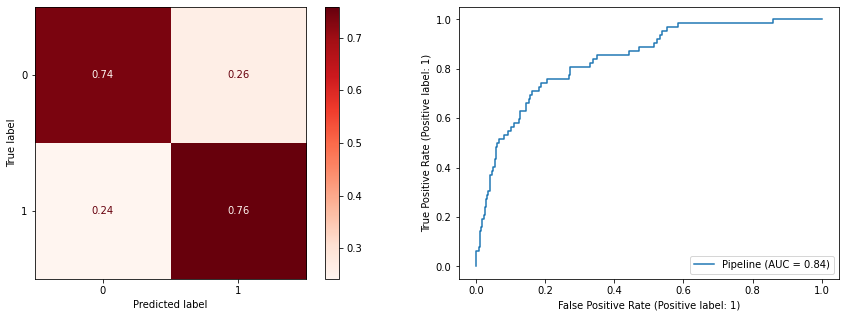

In [174]:
logreg_pca_smote_pipe = smote_pca_model(LogisticRegression(random_state =42, max_iter =1000))
evaluate_classiffication(logreg_pca_smote_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(logreg_pca_smote_pipe, X_test, y_test, label="Test Data")

- When I tried the oversmapling with smote due to the imbalanceness of the data set and applied PCA, the false negative(FN) percentage decreased 99% to 24%.
- The recall score also increased to 0.76 for postive cases.
- According to the results, this model is more similar to the model only with SMOTE.

#KNN Model

##Initial Model

In [175]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b19ae80>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3645
           1       0.80      0.11      0.19       187

    accuracy                           0.96      3832
   macro avg       0.88      0.55      0.58      3832
weighted avg       0.95      0.96      0.94      3832



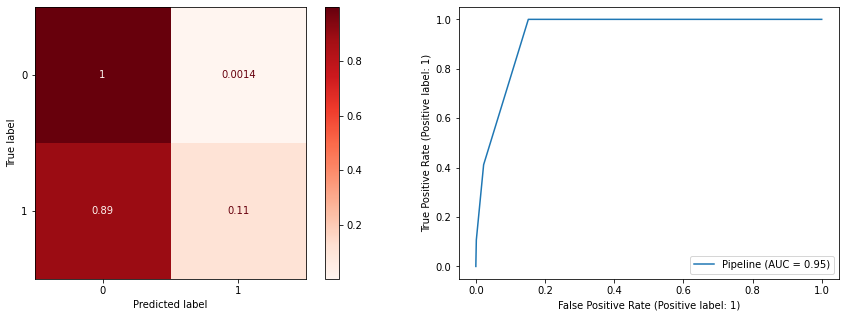

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.90      0.94      0.92      1278



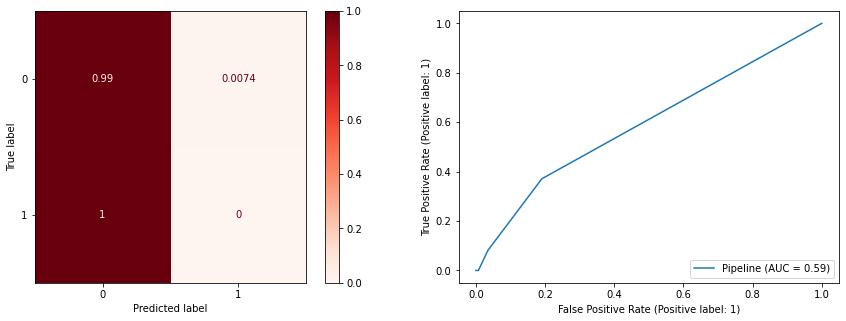

In [176]:
evaluate_classiffication(knn_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(knn_pipe, X_test, y_test, label="Test Data")

- The initial KNN model is not producting true postives for test data at all while show all postive cases as negatives.
- The quality of the model of test data is even lower for KNN model comparative to Logestic regression model.

##with PCA


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3645
           1       0.80      0.11      0.19       187

    accuracy                           0.96      3832
   macro avg       0.88      0.55      0.58      3832
weighted avg       0.95      0.96      0.94      3832



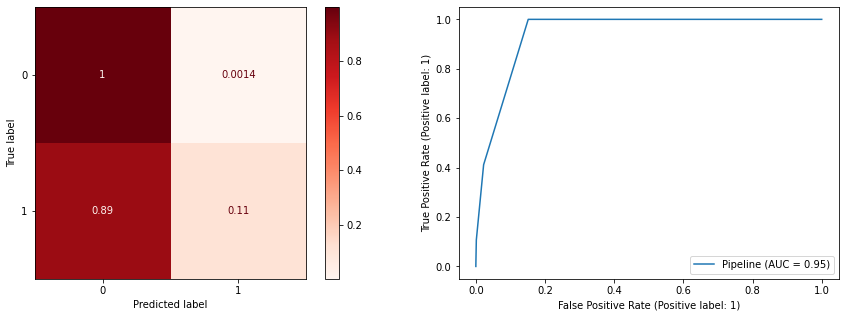

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.90      0.94      0.92      1278



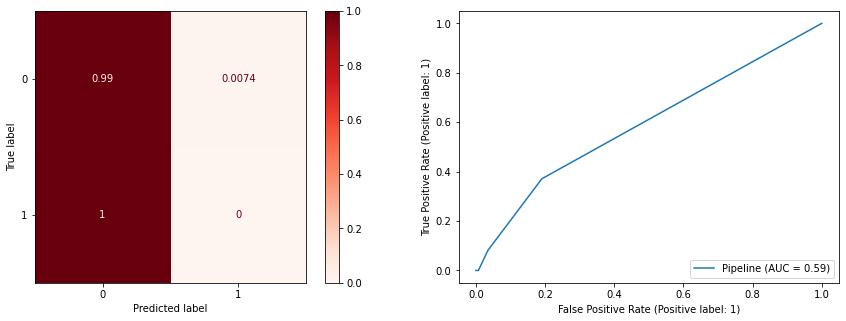

In [177]:
knn_pca_pipe = pca_model(KNeighborsClassifier())
evaluate_classiffication(knn_pca_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(knn_pca_pipe, X_test, y_test, label="Test Data")

As logestic regression model, applying PCA did not change the results.

## With SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      3645
           1       0.30      1.00      0.46       187

    accuracy                           0.89      3832
   macro avg       0.65      0.94      0.70      3832
weighted avg       0.97      0.89      0.91      3832



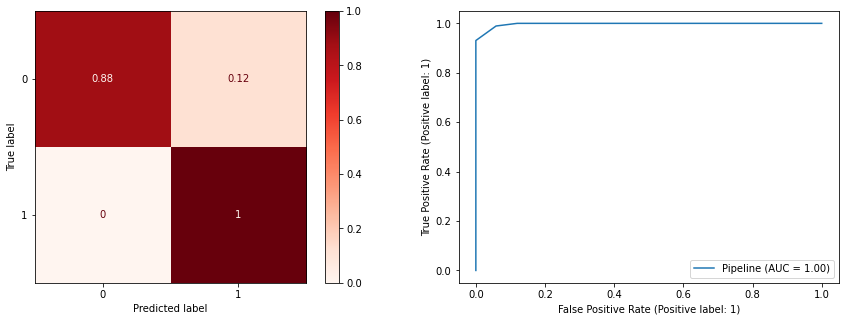

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1216
           1       0.08      0.29      0.12        62

    accuracy                           0.79      1278
   macro avg       0.52      0.55      0.50      1278
weighted avg       0.91      0.79      0.85      1278



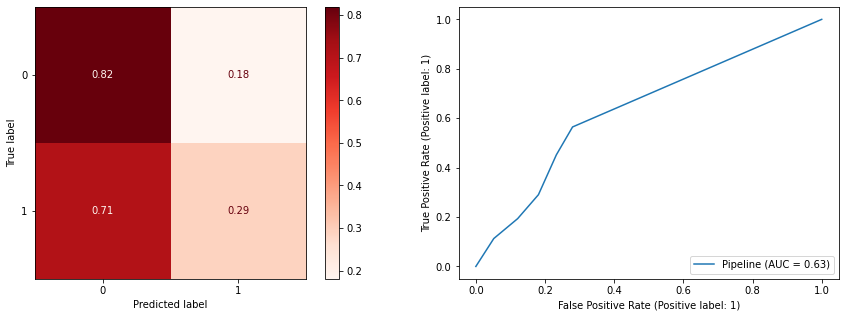

In [178]:
knn_smote_pipe = smote_model(KNeighborsClassifier())
evaluate_classiffication(knn_smote_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(knn_smote_pipe, X_test, y_test, label="Test Data")

According to the results of KNN model with SMOTE, we can say that there is an overfitting problem.

##with both PCA and SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      3645
           1       0.30      1.00      0.46       187

    accuracy                           0.89      3832
   macro avg       0.65      0.94      0.70      3832
weighted avg       0.97      0.89      0.91      3832



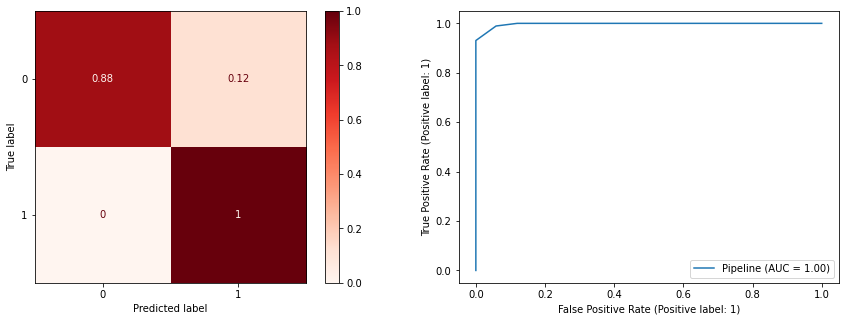

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1216
           1       0.08      0.29      0.12        62

    accuracy                           0.79      1278
   macro avg       0.52      0.55      0.50      1278
weighted avg       0.91      0.79      0.85      1278



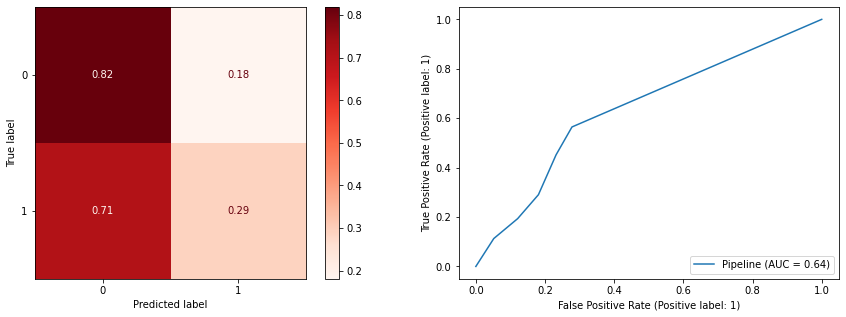

In [179]:
knn_pca_smote_pipe = smote_pca_model(KNeighborsClassifier())
evaluate_classiffication(knn_pca_smote_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(knn_pca_smote_pipe, X_test, y_test, label="Test Data")

- The results are same as the model just using SMOTE 

#Random Forest Model

##Initial Model

In [180]:
rf = RandomForestClassifier(random_state =42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b19ae80>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       1.00      1.00      1.00       187

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832



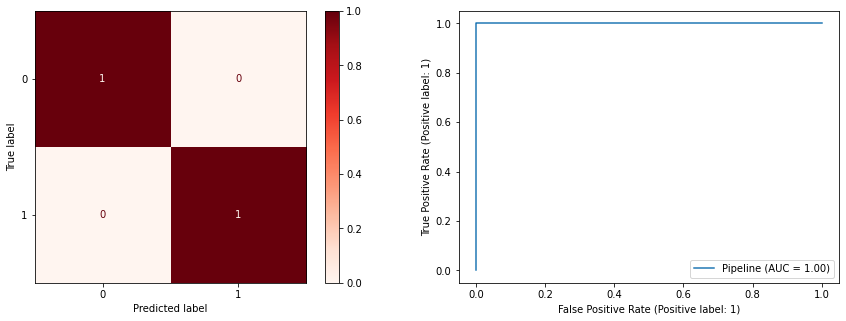

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1216
           1       0.20      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.58      0.51      0.50      1278
weighted avg       0.92      0.95      0.93      1278



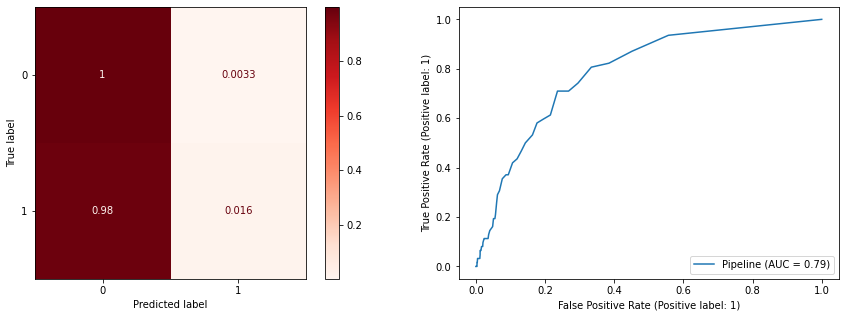

In [181]:
evaluate_classiffication(rf_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(rf_pipe, X_test, y_test, label="Test Data")

- The initial random forest model for has perfectly fit with train data but provide ppor results for test data which says the model is not good.
- The recall scores and percentage of FN are similar to the values obtained for initial model of logestic regression.
- According to the ROC, the quality of the initial model of random forest is lower than the initial model of logestic regression (for test data).

## with PCA

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       1.00      1.00      1.00       187

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832



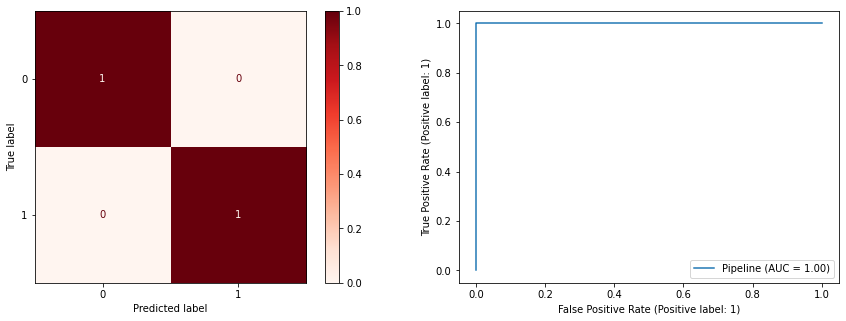

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1216
           1       0.25      0.03      0.06        62

    accuracy                           0.95      1278
   macro avg       0.60      0.51      0.52      1278
weighted avg       0.92      0.95      0.93      1278



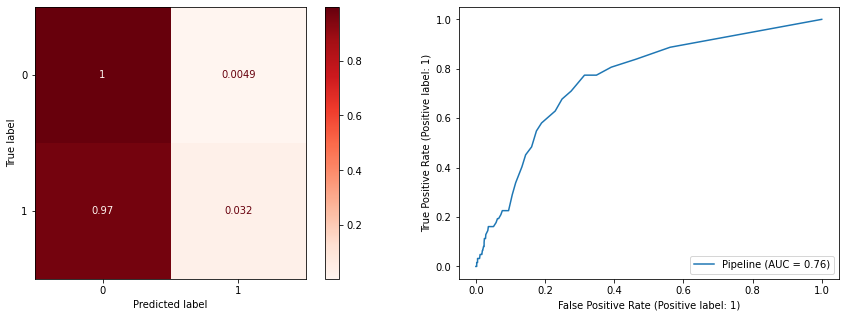

In [182]:
rf_pca_pipe = pca_model(RandomForestClassifier(random_state =42))
evaluate_classiffication(rf_pca_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(rf_pca_pipe, X_test, y_test, label="Test Data")

Just showed tiny improvement for test data, but it is not sufficient.

## with SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       1.00      1.00      1.00       187

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832



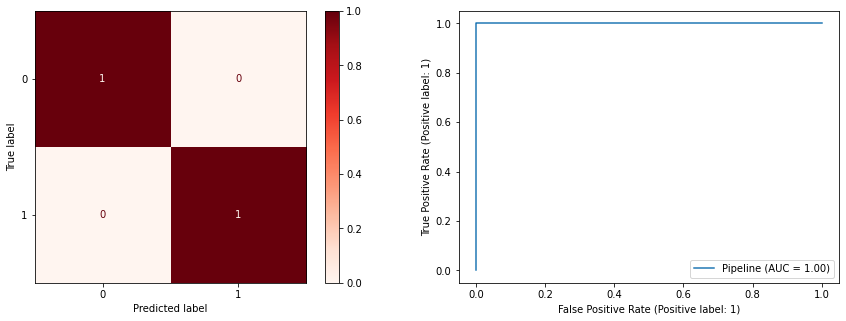

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1216
           1       0.09      0.10      0.09        62

    accuracy                           0.91      1278
   macro avg       0.52      0.52      0.52      1278
weighted avg       0.91      0.91      0.91      1278



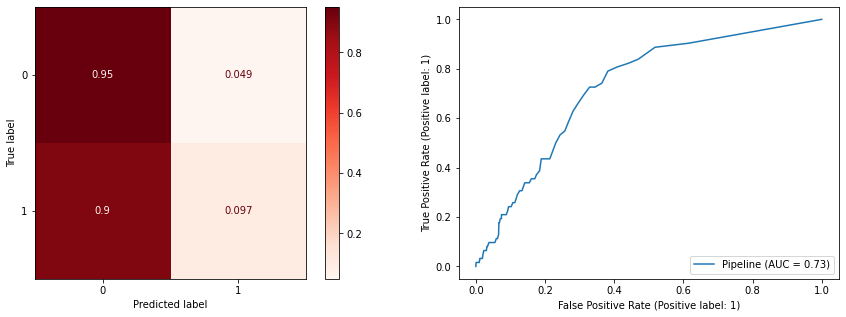

In [183]:
rf_smote_pipe = smote_model(RandomForestClassifier(random_state =42))
evaluate_classiffication(rf_smote_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(rf_smote_pipe, X_test, y_test, label="Test Data")

- FN 98% has reduced to 90% which is good
- Just similar to results of KNN with SMOTE
- Also, suffering from overfitting

##with both PCA and SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       1.00      1.00      1.00       187

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832



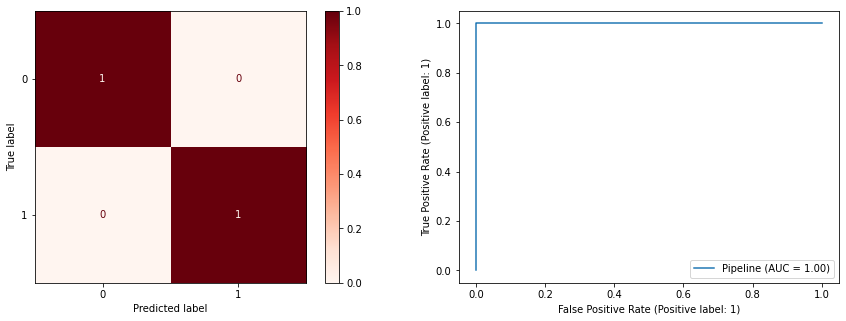

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1216
           1       0.09      0.16      0.11        62

    accuracy                           0.88      1278
   macro avg       0.52      0.54      0.53      1278
weighted avg       0.91      0.88      0.90      1278



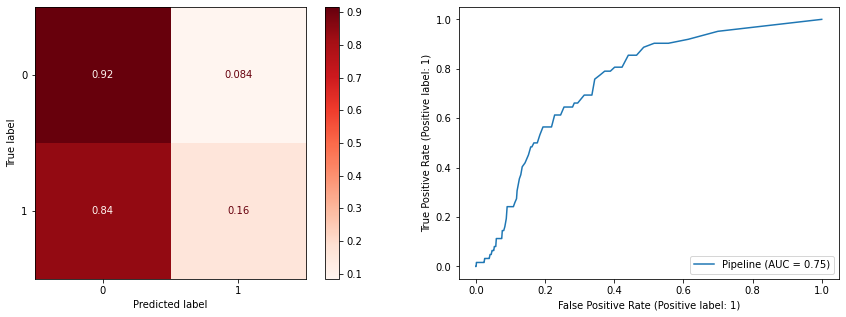

In [184]:
rf_pca_smote_pipe = smote_pca_model(RandomForestClassifier(random_state =42))
evaluate_classiffication(rf_pca_smote_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(rf_pca_smote_pipe, X_test, y_test, label="Test Data")

- For the random forest model with both PCA and SMOTE, the FN percentage has decreased from 97% to 84% which is a small improvement.

#XGBoost Model


## Initial Model

In [185]:
xgb = XGBClassifier(random_state = 42)
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b19ae80>)])),
                ('xgbclassifier', XGBClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3645
           1       1.00      0.03      0.06       187

    accuracy                           0.95      3832
   macro avg       0.98      0.52      0.52      3832
weighted avg       0.96      0.95      0.93      3832



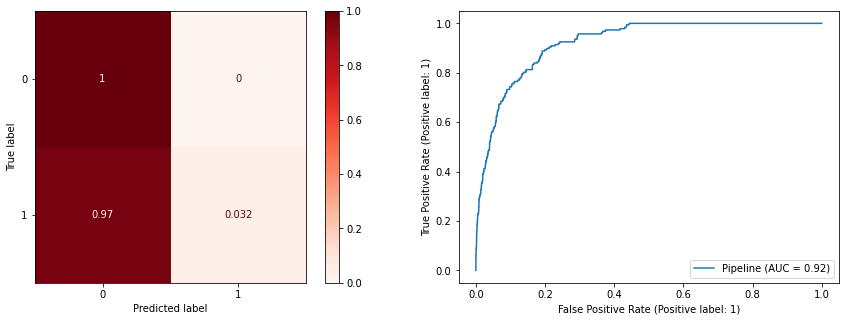

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


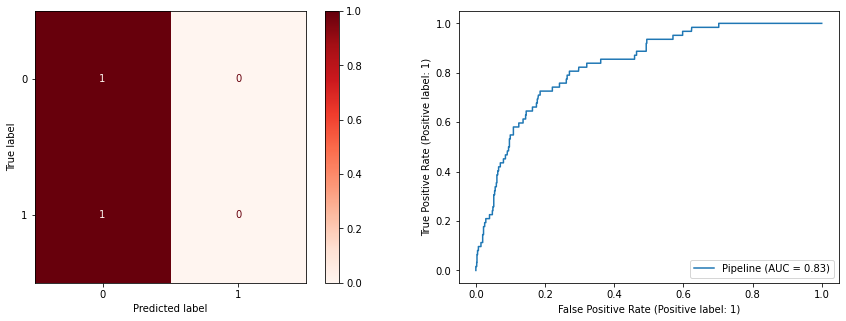

In [186]:
evaluate_classiffication(xgb_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(xgb_pipe, X_test, y_test, label="Test Data")

## with PCA

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3645
           1       1.00      0.07      0.14       187

    accuracy                           0.95      3832
   macro avg       0.98      0.54      0.56      3832
weighted avg       0.96      0.95      0.94      3832



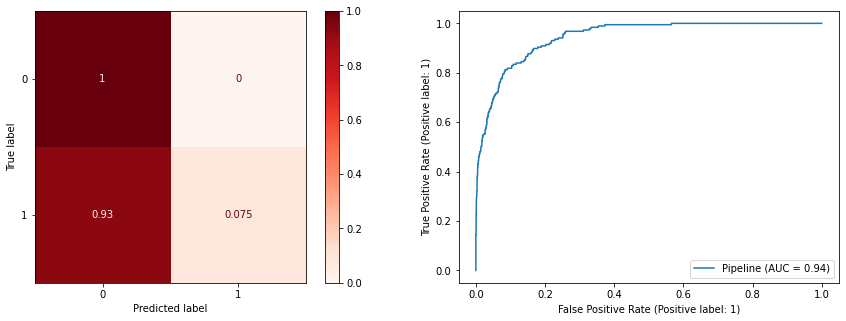

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.50      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.73      0.51      0.50      1278
weighted avg       0.93      0.95      0.93      1278



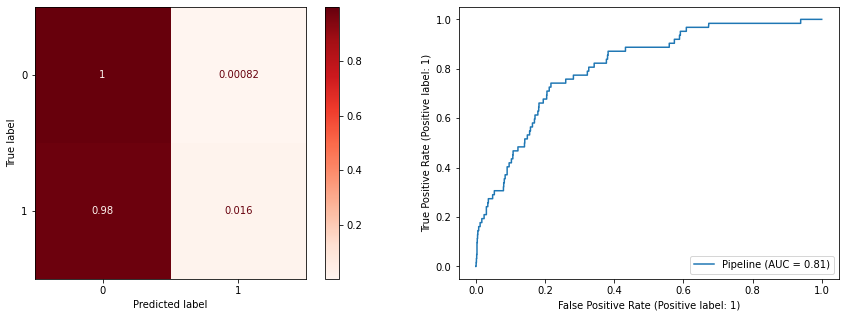

In [187]:
xgb_pca_pipe = pca_model(XGBClassifier(random_state =42))
evaluate_classiffication(xgb_pca_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(xgb_pca_pipe, X_test, y_test, label="Test Data")

## with SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3645
           1       0.22      0.64      0.33       187

    accuracy                           0.87      3832
   macro avg       0.60      0.76      0.63      3832
weighted avg       0.94      0.87      0.90      3832



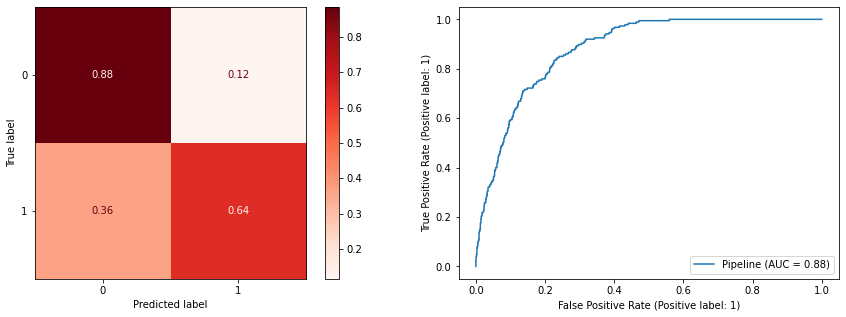

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      1216
           1       0.14      0.47      0.21        62

    accuracy                           0.83      1278
   macro avg       0.55      0.66      0.56      1278
weighted avg       0.93      0.83      0.87      1278



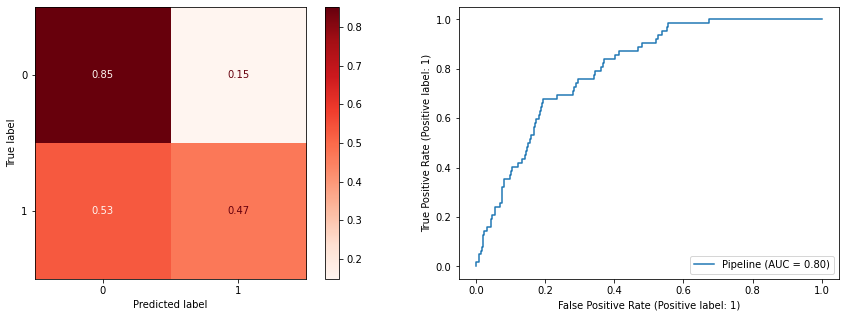

In [188]:
xgb_smote_pipe = smote_model(XGBClassifier(random_state =42))
evaluate_classiffication(xgb_smote_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(xgb_smote_pipe, X_test, y_test, label="Test Data")

##with both PCA and SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      3645
           1       0.21      0.90      0.34       187

    accuracy                           0.83      3832
   macro avg       0.60      0.86      0.62      3832
weighted avg       0.96      0.83      0.87      3832



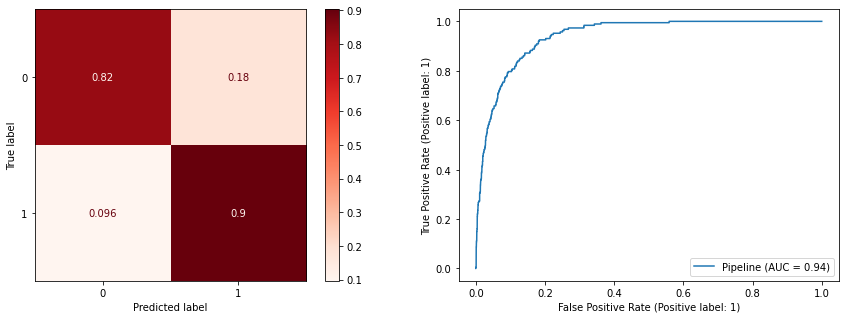

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1216
           1       0.13      0.60      0.21        62

    accuracy                           0.78      1278
   macro avg       0.55      0.69      0.54      1278
weighted avg       0.93      0.78      0.84      1278



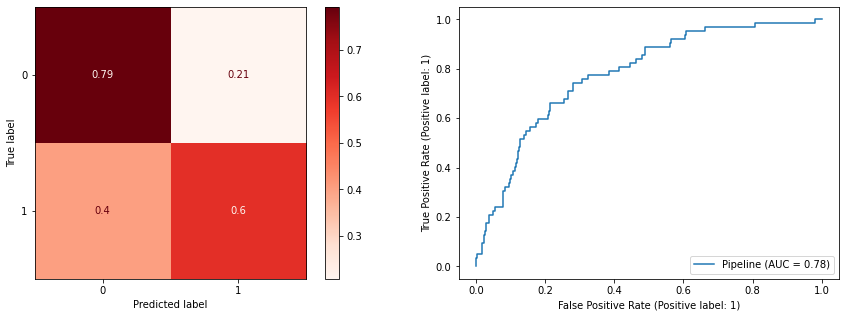

In [189]:
xgb_pca_smote_pipe = smote_pca_model(XGBClassifier(random_state =42))
evaluate_classiffication(xgb_pca_smote_pipe, X_train, y_train, label="Train Data")
evaluate_classiffication(xgb_pca_smote_pipe, X_test, y_test, label="Test Data")

- This model got the better scores for training data.
- There's a overfitting problem when the test scores compare with training scores, but yet performing well for testing data comparative to the 
most of other tested models.

- Out of all initial models of classification models I used, logistic regresion was the good one.
- It can be further improved by SMOTE oversampling.

In [190]:
def eval_summary_classification(pipe, X, y):
  
  pred = pipe.predict(X)

  precision= round(precision_score(y, pred),3)
  recall = round(recall_score(y, pred),3)
  f1 = round(f1_score(y, pred),3)
  accuracy = round(accuracy_score(y, pred),3)
  roc = round(roc_auc_score(y, pipe.predict_proba(X)[:,1]),3)

  return (precision, recall, f1, accuracy, roc)

# Summary of pre-optimized models

In [191]:
iscores = pd.DataFrame()

model = ['Logistic Regression' ,'Logistic Regression with PCA','Logistic Regression with SMOTE', 'Logistic Regression with PCA & SMOTE ','KNN', 'KNN with PCA', 'KNN with SMOTE', 'KNN with PCA and SMOTE','Random Forest', 'Random Forest with PCA', 'Random Forest with SMOTE', 'Random Forest with PCA and SMOTE','XGBoost', 'XGBoost with PCA', 'XGBoost with SMOTE', 'XGBoost with PCA and SMOTE']
pipe = [logreg_pipe, logreg_pca_pipe, logreg_smote_pipe, logreg_pca_smote_pipe,knn_pipe, knn_pca_pipe, knn_smote_pipe, knn_pca_smote_pipe,rf_pipe, rf_pca_pipe, rf_smote_pipe, rf_pca_smote_pipe,xgb_pipe, xgb_pca_pipe, xgb_smote_pipe, xgb_pca_smote_pipe]

for i in range(len(model)):
  iscores.loc[i, 'Model'] = model[i]
  iscores.loc[i,'Precision_train'], iscores.loc[i,'Recall_train'], iscores.loc[i,'F1 Score_train'], iscores.loc[i,'Accuracy_train'], iscores.loc[i,'ROC AUC Score_train'] = eval_summary_classification(pipe[i], X_train, y_train)
  iscores.loc[i,'Precision_test'], iscores.loc[i,'Recall_test'], iscores.loc[i,'F1 Score_test'], iscores.loc[i,'Accuracy_test'], iscores.loc[i,'ROC AUC Score_test'] = eval_summary_classification(pipe[i], X_test, y_test)
  

  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
iscores

,Model,Precision_train,Recall_train,F1 Score_train,Accuracy_train,ROC AUC Score_train,Precision_test,Recall_test,F1 Score_test,Accuracy_test,ROC AUC Score_test
0,Logistic Regression,0.000,0.000,0.000,0.951,0.848,1.000,0.016,0.032,0.952,0.841
1,Logistic Regression with PCA,0.000,0.000,0.000,0.951,0.848,1.000,0.016,0.032,0.952,0.841
2,Logistic Regression with SMOTE,0.139,0.786,0.236,0.751,0.846,0.128,0.758,0.219,0.738,0.840
3,Logistic Regression with PCA & SMOTE,0.139,0.786,0.236,0.751,0.846,0.128,0.758,0.220,0.739,0.840
4,KNN,0.800,0.107,0.189,0.955,0.945,0.000,0.000,0.000,0.944,0.591
5,KNN with PCA,0.800,0.107,0.189,0.955,0.945,0.000,0.000,0.000,0.944,0.591
6,KNN with SMOTE,0.300,1.000,0.462,0.886,0.997,0.076,0.290,0.120,0.793,0.635
7,KNN with PCA and SMOTE,0.300,1.000,0.462,0.886,0.997,0.076,0.290,0.120,0.793,0.635
8,Random Forest,1.000,1.000,1.000,1.000,1.000,0.200,0.016,0.030,0.949,0.789
9,Random Forest with PCA,1.000,1.000,1.000,1.000,1.000,0.250,0.032,0.057,0.948,0.757


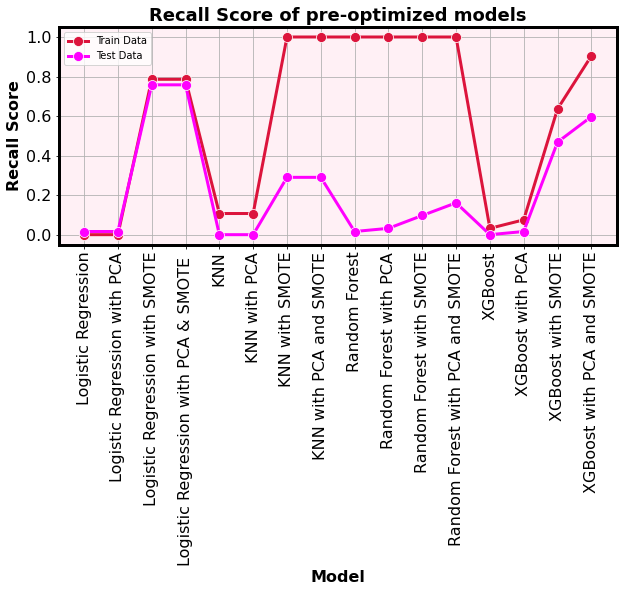

In [193]:
fig, ax = plt.subplots(nrows=1, figsize=(10,4), facecolor='w')
ax.set_facecolor('lavenderblush')
sns.lineplot(data = iscores, x ='Model', y= 'Recall_train', label= 'Train Data', color = 'crimson', linewidth=3, markersize=10, marker='o')
sns.lineplot(data = iscores, x ='Model', y= 'Recall_test', label= 'Test Data', color="magenta", linewidth=3, markersize=10, marker='o')
plt.xticks(rotation = 90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Recall Score',  fontsize = 16, fontweight ='bold')
plt.xlabel('Model',  fontsize = 16, fontweight ='bold')
plt.title('Recall Score of pre-optimized models', fontsize = 18, fontweight ='bold')
plt.grid()
plt.legend()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3);

- For all tested models, the best recall score obtained when they are incorporated with both PCA and SMOTE. 
- Therefore, I'm going to optimize the paramaters of those models to enhance the performence.

#Optimizing the models

##For Logistic Regression model

In [194]:
logreg_pca_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                

In [195]:
logreg_param_grid = {'smote__k_neighbors':range(2,7),
                 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [196]:
logreg_gs = GridSearchCV(logreg_pca_smote_pipe, logreg_param_grid, cv =5)
logreg_gs.fit(X_train, y_train);

In [197]:
print(f'Best parameters: {logreg_gs.best_params_}')

Best parameters: {'logisticregression__C': 0.0001, 'smote__k_neighbors': 2}


In [198]:
logreg_opt = logreg_gs.best_estimator_
logreg_opt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9d4b37f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9d4b3f70>)])),
                ('pca', PCA(n_components=13)),
                ('smote', SMOTE(k_neighbors=2, random_state=42)),
                ('logisticregression',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      3645
           1       0.13      0.74      0.23       187

    accuracy                           0.75      3832
   macro avg       0.56      0.75      0.54      3832
weighted avg       0.94      0.75      0.82      3832



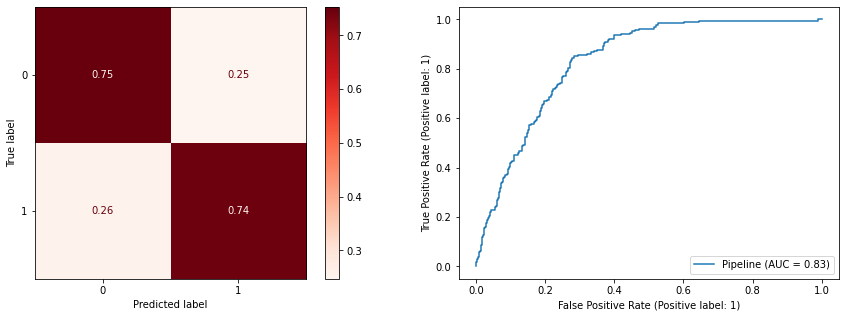

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1216
           1       0.14      0.77      0.23        62

    accuracy                           0.75      1278
   macro avg       0.56      0.76      0.54      1278
weighted avg       0.94      0.75      0.82      1278



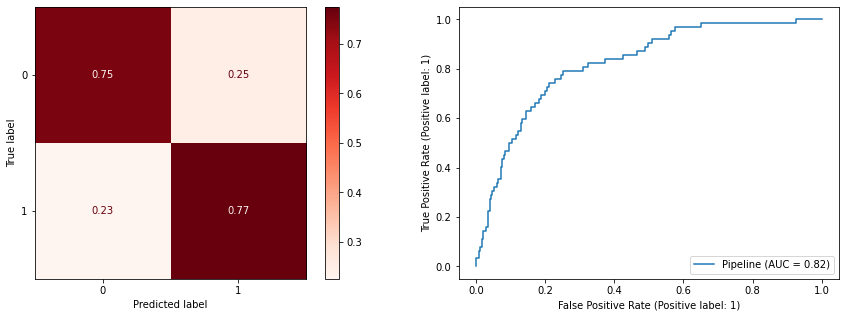

In [199]:
evaluate_classiffication(logreg_opt, X_train, y_train, label="Train Data")
evaluate_classiffication(logreg_opt, X_test, y_test, label="Test Data")

##For KNN model

In [200]:
knn_pca_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                

In [201]:
knn_param_grid = {'smote__k_neighbors':range(1,7)}

In [202]:
knn_gs = GridSearchCV(knn_pca_smote_pipe, knn_param_grid, cv =5)
knn_gs.fit(X_train, y_train);

In [203]:
print(f'Best parameters: {knn_gs.best_params_}')

Best parameters: {'smote__k_neighbors': 1}


In [204]:
knn_opt = knn_gs.best_estimator_
knn_opt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9d4bcb80>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9a84ed00>)])),
                ('pca', PCA(n_components=13)),
                ('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      3645
           1       0.34      1.00      0.50       187

    accuracy                           0.90      3832
   macro avg       0.67      0.95      0.72      3832
weighted avg       0.97      0.90      0.92      3832



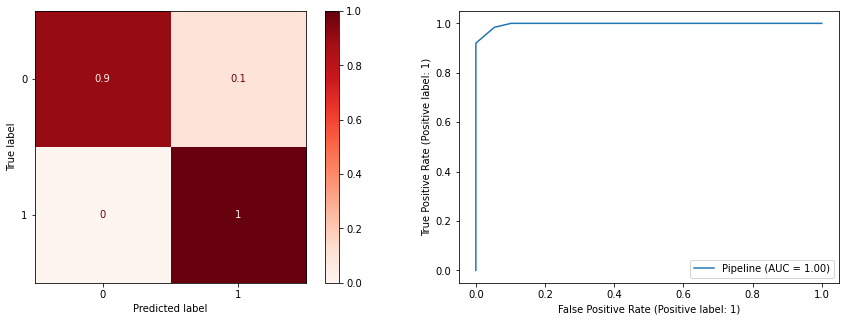

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1216
           1       0.07      0.24      0.11        62

    accuracy                           0.82      1278
   macro avg       0.52      0.54      0.51      1278
weighted avg       0.91      0.82      0.86      1278



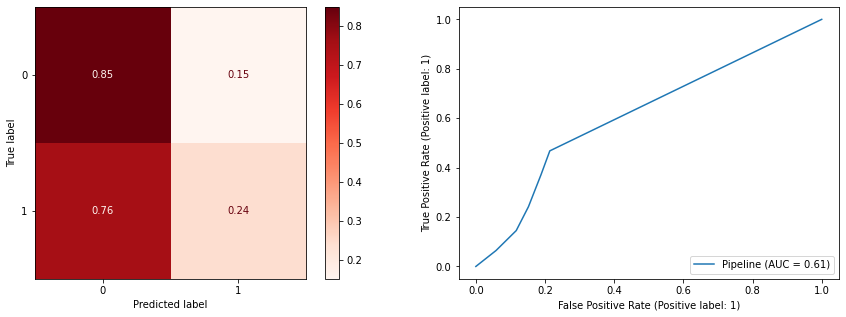

In [205]:
evaluate_classiffication(knn_opt, X_train, y_train, label="Train Data")
evaluate_classiffication(knn_opt, X_test, y_test, label="Test Data")

##For Random Forest Model

In [206]:
rf_pca_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                

In [207]:
rf_param_grid = {'smote__k_neighbors':range(1,7),
                 'randomforestclassifier__n_estimators': [20,30,50,100,150,200]}

In [208]:
rf_gs = GridSearchCV(rf_pca_smote_pipe, rf_param_grid, cv =5)
rf_gs.fit(X_train, y_train);

In [209]:
print(f'Best parameters: {rf_gs.best_params_}')

Best parameters: {'randomforestclassifier__n_estimators': 150, 'smote__k_neighbors': 1}


In [210]:
rf_opt = rf_gs.best_estimator_
rf_opt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9aa25430>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9d4a4400>)])),
                ('pca', PCA(n_components=13)),
                ('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       1.00      1.00      1.00       187

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832



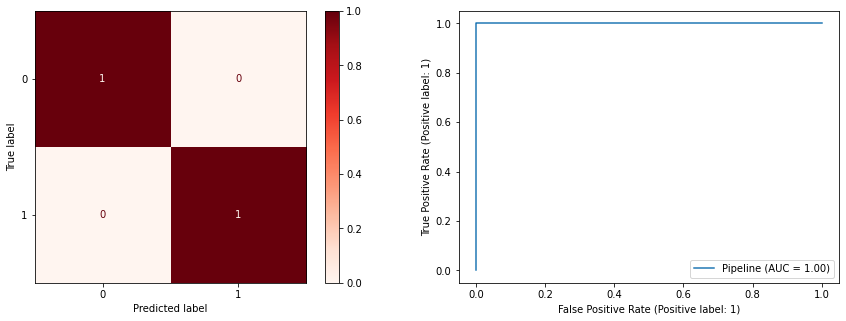

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1216
           1       0.07      0.08      0.08        62

    accuracy                           0.91      1278
   macro avg       0.51      0.51      0.51      1278
weighted avg       0.91      0.91      0.91      1278



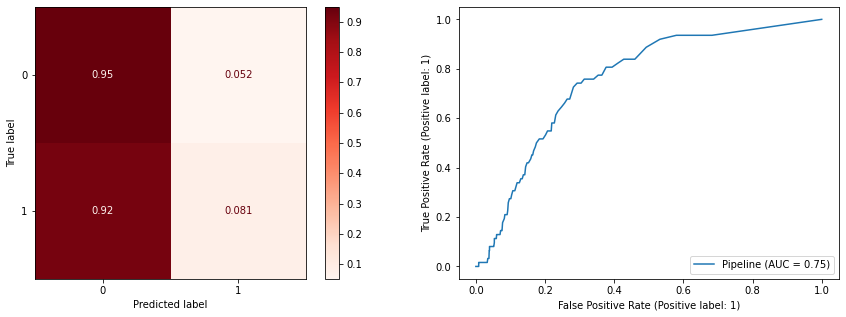

In [211]:
evaluate_classiffication(rf_opt, X_train, y_train, label="Train Data")
evaluate_classiffication(rf_opt, X_test, y_test, label="Test Data")

##For XGBoost Model

In [212]:
xgb_pca_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9b06da90>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                

In [213]:
xgb_param_grid = {'smote__k_neighbors': range(1,7),
                  'xgbclassifier__base_score': [0.1, 0.25, 0.5, 0.75]}

In [214]:
xgb_gs = GridSearchCV(xgb_pca_smote_pipe, xgb_param_grid, cv =5)
xgb_gs.fit(X_train, y_train);

In [215]:
print(f'Best parameters: {xgb_gs.best_params_}')

Best parameters: {'smote__k_neighbors': 1, 'xgbclassifier__base_score': 0.25}


In [216]:
xgb_opt = xgb_gs.best_estimator_
xgb_opt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9af23880>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6b9af233d0>)])),
                ('pca', PCA(n_components=13)),
                ('smote', SMOTE(k_neighbors=1, random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.25, random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3645
           1       0.22      0.88      0.35       187

    accuracy                           0.84      3832
   macro avg       0.61      0.86      0.63      3832
weighted avg       0.96      0.84      0.88      3832



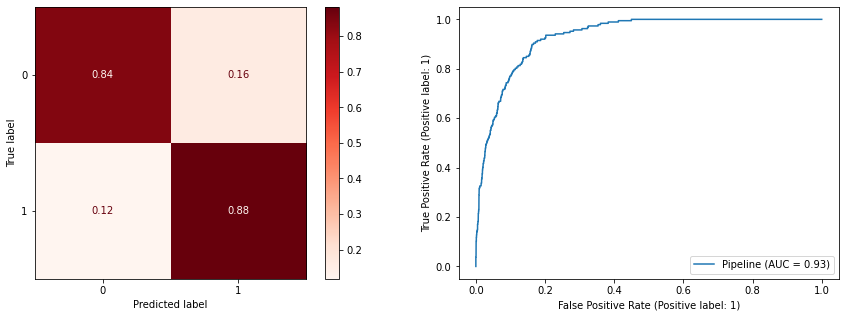

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      1216
           1       0.14      0.61      0.22        62

    accuracy                           0.79      1278
   macro avg       0.56      0.71      0.55      1278
weighted avg       0.94      0.79      0.85      1278



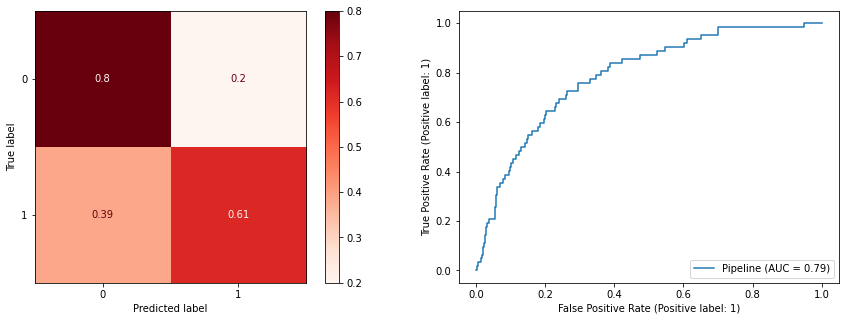

In [217]:
evaluate_classiffication(xgb_opt, X_train, y_train, label="Train Data")
evaluate_classiffication(xgb_opt, X_test, y_test, label="Test Data")

#Comparison between pre and post optimized Models

In [218]:
opt_scores = pd.DataFrame()

model = ['Logistic Regression' , 'Optimized Logistic Regression','KNN', 'Optimized KNN', 'Random Forest', 'Optimized Random Forest','XGBoost','Optimized XGBoost']
pipe = [logreg_pca_smote_pipe, logreg_opt, knn_pca_smote_pipe, knn_opt, rf_pca_smote_pipe, rf_opt, xgb_pca_smote_pipe, xgb_opt]

for i in range(len(model)):
  opt_scores.loc[i, 'Model'] = model[i]
  opt_scores.loc[i,'Precision_train'], opt_scores.loc[i,'Recall_train'], opt_scores.loc[i,'F1 Score_train'], opt_scores.loc[i,'Accuracy_train'], opt_scores.loc[i,'ROC AUC Score_train'] = eval_summary_classification(pipe[i], X_train, y_train)
  opt_scores.loc[i,'Precision_test'], opt_scores.loc[i,'Recall_test'], opt_scores.loc[i,'F1 Score_test'], opt_scores.loc[i,'Accuracy_test'], opt_scores.loc[i,'ROC AUC Score_test'] = eval_summary_classification(pipe[i], X_test, y_test)
  

  

In [219]:
opt_scores = opt_scores.set_index('Model')

In [220]:
opt_scores

,Precision_train,Recall_train,F1 Score_train,Accuracy_train,ROC AUC Score_train,Precision_test,Recall_test,F1 Score_test,Accuracy_test,ROC AUC Score_test
Model,,,,,,,,,,
Logistic Regression,0.139,0.786,0.236,0.751,0.846,0.128,0.758,0.220,0.739,0.840
Optimized Logistic Regression,0.134,0.743,0.227,0.752,0.831,0.138,0.774,0.234,0.754,0.820
KNN,0.300,1.000,0.462,0.886,0.997,0.076,0.290,0.120,0.793,0.635
Optimized KNN,0.336,1.000,0.503,0.903,0.997,0.075,0.242,0.115,0.818,0.614
Random Forest,1.000,1.000,1.000,1.000,1.000,0.089,0.161,0.115,0.879,0.749
Optimized Random Forest,1.000,1.000,1.000,1.000,1.000,0.074,0.081,0.077,0.906,0.755
XGBoost,0.209,0.904,0.339,0.828,0.940,0.128,0.597,0.211,0.783,0.779
Optimized XGBoost,0.220,0.882,0.353,0.842,0.932,0.135,0.613,0.222,0.791,0.788


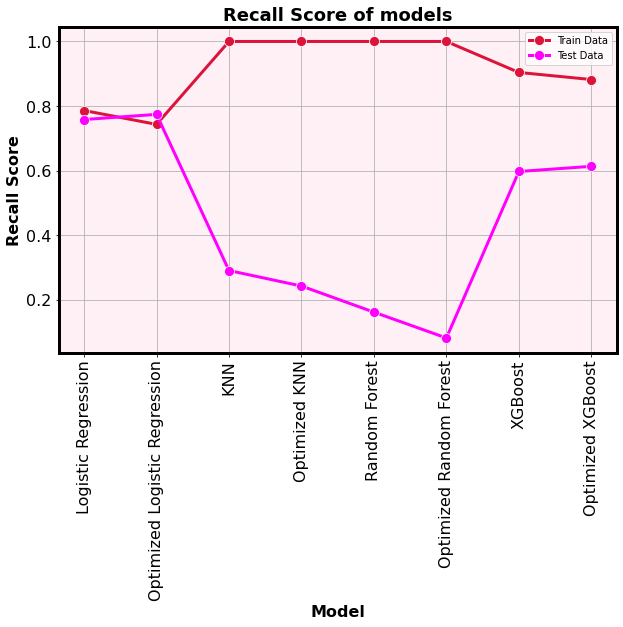

In [221]:
fig, ax = plt.subplots(nrows=1, figsize=(10,6), facecolor='w')
ax.set_facecolor('lavenderblush')
sns.lineplot(data = opt_scores, x ='Model', y= 'Recall_train', label= 'Train Data', color = 'crimson', linewidth=3, markersize=10, marker='o',)
sns.lineplot(data = opt_scores, x ='Model', y= 'Recall_test', label= 'Test Data', color="magenta", linewidth=3, markersize=10, marker='o',)
plt.xticks(rotation = 90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Recall Score',  fontsize = 16, fontweight ='bold')
plt.xlabel('Model',  fontsize = 16, fontweight ='bold')
plt.title('Recall Score of models', fontsize = 18, fontweight ='bold')
plt.grid()
plt.legend()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3);

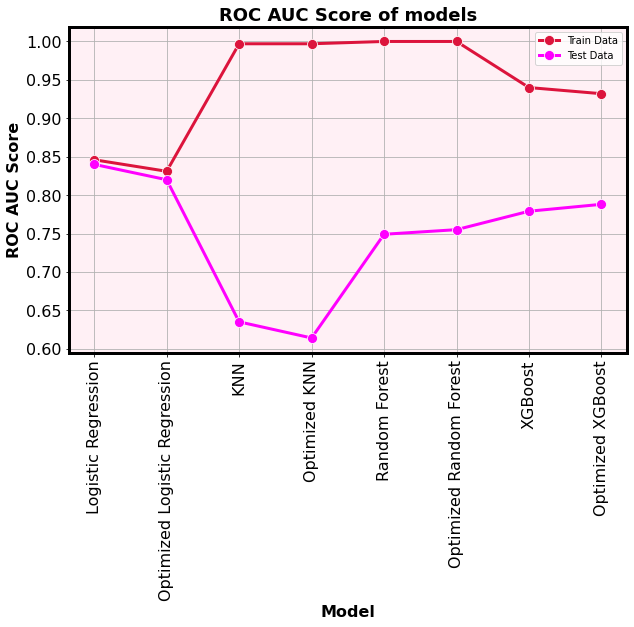

In [222]:
fig, ax = plt.subplots(nrows=1, figsize=(10,6), facecolor='w')
ax.set_facecolor('lavenderblush')
sns.lineplot(data = opt_scores, x ='Model', y= 'ROC AUC Score_train', label= 'Train Data', color = 'crimson', linewidth=3, markersize=10, marker='o',)
sns.lineplot(data = opt_scores, x ='Model', y= 'ROC AUC Score_test', label= 'Test Data', color="magenta", linewidth=3, markersize=10, marker='o',)
plt.xticks(rotation = 90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('ROC AUC Score',  fontsize = 16, fontweight ='bold')
plt.xlabel('Model',  fontsize = 16, fontweight ='bold')
plt.title('ROC AUC Score of models', fontsize = 18, fontweight ='bold')
plt.grid()
plt.legend()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3);

- Out of the 4 models, the optimized logistic regression model can be selected as best model according to the recall score and ROC score.
- Especially in this project, we are trying to maximize recall score to minimize the risk on patietns.
- The logistic regression models are the ones identified as the minimal overfitting models because their training scores are approximately similar with testing scores.
- The optimized logitic regression model not only gained the highest testing recall score, it also performed very well on testing data over training data according to the recall score.
- Therefore, optimized logistic regression model is the best model to predict the risk of stoke of patients.